In [1]:
from neural_agent import Brain
import gym
import tensorflow as tf
import tensorflow_probability as tfp
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_probability as tfp
import seaborn as sns
import numpy as np

In [2]:
mu = 0.0
sigma = 1.0

continuous_policy = tfp.distributions.Normal(loc=mu,scale=sigma)
for i in range(10):
    action = continuous_policy.sample(1)
    print(action)

tf.Tensor([0.47009784], shape=(1,), dtype=float32)
tf.Tensor([-0.59856796], shape=(1,), dtype=float32)
tf.Tensor([1.1034161], shape=(1,), dtype=float32)
tf.Tensor([-0.10888135], shape=(1,), dtype=float32)
tf.Tensor([-0.48659188], shape=(1,), dtype=float32)
tf.Tensor([-0.12187228], shape=(1,), dtype=float32)
tf.Tensor([0.40948576], shape=(1,), dtype=float32)
tf.Tensor([0.10108351], shape=(1,), dtype=float32)
tf.Tensor([1.3705468], shape=(1,), dtype=float32)
tf.Tensor([1.9684589], shape=(1,), dtype=float32)


<Axes: ylabel='Count'>

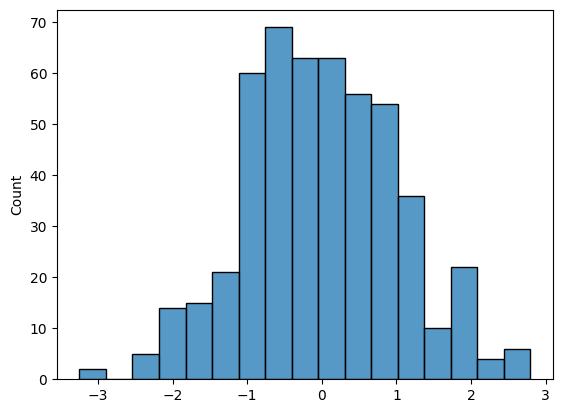

In [3]:
sample_actions = continuous_policy.sample(500)
sns.histplot(sample_actions)

In [4]:
mu = [0.0, 0.0]
covariance_diag = [3.0, 3.0]
continuous_multidim_policy = tfp.distributions.MultivariateNormalDiag(loc=mu, scale_diag=covariance_diag)
# action = continuous_multidim_policy.sample(10)
for i in range(10):
    action = continuous_multidim_policy.sample(1)
    print(action)

tf.Tensor([[-3.3921614   0.14912516]], shape=(1, 2), dtype=float32)
tf.Tensor([[-0.29824656 -2.0947104 ]], shape=(1, 2), dtype=float32)
tf.Tensor([[ 2.5357943 -3.3450952]], shape=(1, 2), dtype=float32)
tf.Tensor([[-2.8563273  3.4169416]], shape=(1, 2), dtype=float32)
tf.Tensor([[5.7035685 2.8652353]], shape=(1, 2), dtype=float32)
tf.Tensor([[-1.6234331 -0.958966 ]], shape=(1, 2), dtype=float32)
tf.Tensor([[ 5.723915  -0.6247247]], shape=(1, 2), dtype=float32)
tf.Tensor([[-2.0927846 -1.6330469]], shape=(1, 2), dtype=float32)
tf.Tensor([[ 0.2318942 -0.6746813]], shape=(1, 2), dtype=float32)
tf.Tensor([[-0.51198196 -2.2695642 ]], shape=(1, 2), dtype=float32)


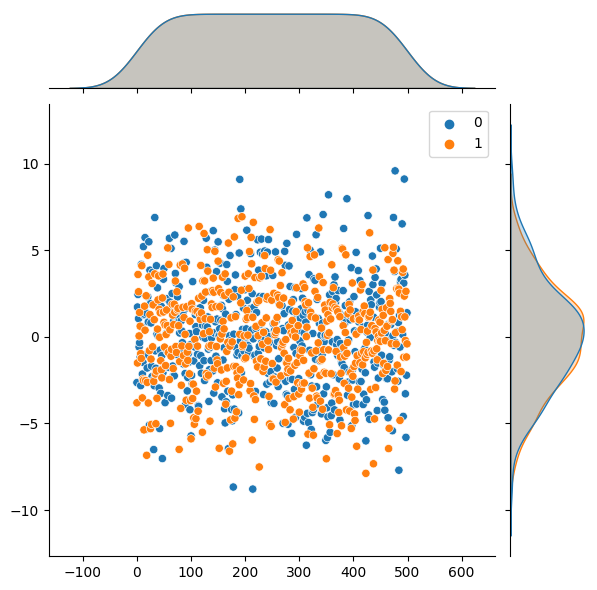

In [5]:
sample_actions = continuous_multidim_policy.sample(500)
sns.jointplot(data=sample_actions,kind='scatter')
#sns.jointplot(data=sample_actions,x=sample_actions[:, 0],y=sample_actions[:, 1],kind='scatter')

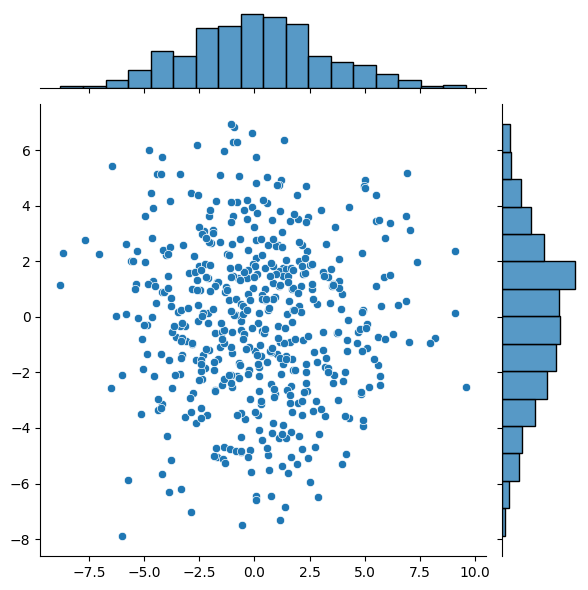

In [6]:
sns.jointplot(data=sample_actions,x=sample_actions[:, 0],y=sample_actions[:, 1],kind='scatter')

<title>RL Network Build</title>

In [7]:
#Continuous Policy Class
class ContinuousPolicy(object):
    def __init__(self, action_dim):
        self.action_dim = action_dim
    def sample(self, mu, var):
        self.distribution = tfp.distributions.Normal(loc=mu, scale=sigma)
        return self.distribution.sample(1)
    def get_action(self, mu, var):
        action = self.sample(mu, var)
        return action

In [8]:
#Multi-Dimensional Continuous Policy Class
class ContinuousMultiDimensionalPolicy(object):
    def __init__(self, num_actions):
        self.action_dim = num_actions
    def sample(self, mu, covariance_diag):
        self.distribution = tfp.distributions.MultivariateNormalDiag(loc=mu,scale_diag=covariance_diag)
        return self.distribution.sample(1)
    def get_action(self, mu, covariance_diag):
        action = self.sample(mu, covariance_diag)
        return action

In [9]:
#Evaluation function for episodic performance
def evaluate(agent, env, render=True):
    obs, episode_reward, done, step_num = env.reset(),0.0, False, 0
    while not done:
        obs.reshape(-1,1)
        #print(f"obs : {obs} obs.shape : {obs.shape} obs.type: {type(obs)}")
        arr = np.array([[obs[0],obs[1]]])
        #print(f"arr : {arr} arr.shape : {arr.shape} obs.type: {type(arr)}")
        action = agent.get_action(arr)
        obs, reward, done, info = env.step(action)
        episode_reward += reward
        step_num += 1
        if render:
            env.render()
    return step_num, episode_reward, done, info

In [10]:
#Implementing a Neural-network Brain class using TensorFlow 2.x.
class Brain(keras.Model):
    def __init__(self, action_dim=5,input_shape=2):
        """Initialize the Agent's Brain model
        Args:
            action_dim (int): Number of actions
        """
        super(Brain, self).__init__()
        self.dense1 = layers.Dense(32,input_shape=(input_shape,), activation="relu")
        self.logits = layers.Dense(action_dim)
        self.summary
        
    def call(self, inputs):
        x = tf.convert_to_tensor(inputs)
        if len(x.shape) >= 2 and x.shape[0] != 1:
            x = tf.reshape(x, (1, -1))
        return self.logits(self.dense1(x))
    
    def process(self, observations):
        # Process batch observations using `call(inputs)`
        # behind-the-scenes
        action_logits = self.predict_on_batch(observations)
        return action_logits

In [11]:
#Agent class utilizing the ContinuousPolicy object to act in continuous action space environments
class Agent(object):
    def __init__(self, action_dim=5,input_dim=(1, 8 * 8)):
        self.brain = Brain(action_dim, input_dim)
        self.policy = ContinuousPolicy(action_dim)
    def get_action(self, obs):
        action_logits = self.brain.process(obs)
        action = self.policy.get_action(*np.squeeze(action_logits, 0))
        return action

In [12]:
env = gym.make("MountainCarContinuous-v0")

In [13]:
action_dim = 2 * env.action_space.shape[0]
input_shape = env.observation_space.shape
#input_array = np.array[env.observation_space]
print(action_dim)


2


In [14]:
action_dim = 2 * env.action_space.shape[0]
# 2 values (mu & sigma) for one action dim
#env.observation_space = env.observation_space.reshape(-1,1)
agent = Agent(action_dim, env.observation_space.shape)
steps, reward, done, info = evaluate(agent, env)
print(f"steps:{steps} reward:{reward} done:{done} info:{info}")
env.close()

obs : [-0.44730306  0.        ] obs.shape : (2,) obs.type: <class 'numpy.ndarray'>
arr : [[-0.44730306  0.        ]] arr.shape : (1, 2) obs.type: <class 'numpy.ndarray'>
obs : [-0.4489349  -0.00163184] obs.shape : (2,) obs.type: <class 'numpy.ndarray'>
arr : [[-0.4489349  -0.00163184]] arr.shape : (1, 2) obs.type: <class 'numpy.ndarray'>
obs : [-0.44962206 -0.00068715] obs.shape : (2,) obs.type: <class 'numpy.ndarray'>
arr : [[-0.44962206 -0.00068715]] arr.shape : (1, 2) obs.type: <class 'numpy.ndarray'>
obs : [-0.4523595  -0.00273743] obs.shape : (2,) obs.type: <class 'numpy.ndarray'>
arr : [[-0.4523595  -0.00273743]] arr.shape : (1, 2) obs.type: <class 'numpy.ndarray'>
obs : [-0.45412716 -0.00176767] obs.shape : (2,) obs.type: <class 'numpy.ndarray'>
arr : [[-0.45412716 -0.00176767]] arr.shape : (1, 2) obs.type: <class 'numpy.ndarray'>
obs : [-0.45791212 -0.00378494] obs.shape : (2,) obs.type: <class 'numpy.ndarray'>
arr : [[-0.45791212 -0.00378494]] arr.shape : (1, 2) obs.type: <cla

obs : [-0.5263935   0.00812338] obs.shape : (2,) obs.type: <class 'numpy.ndarray'>
arr : [[-0.5263935   0.00812338]] arr.shape : (1, 2) obs.type: <class 'numpy.ndarray'>
obs : [-0.518442   0.0079515] obs.shape : (2,) obs.type: <class 'numpy.ndarray'>
arr : [[-0.518442   0.0079515]] arr.shape : (1, 2) obs.type: <class 'numpy.ndarray'>
obs : [-0.51175636  0.00668559] obs.shape : (2,) obs.type: <class 'numpy.ndarray'>
arr : [[-0.51175636  0.00668559]] arr.shape : (1, 2) obs.type: <class 'numpy.ndarray'>
obs : [-0.50365955  0.00809679] obs.shape : (2,) obs.type: <class 'numpy.ndarray'>
arr : [[-0.50365955  0.00809679]] arr.shape : (1, 2) obs.type: <class 'numpy.ndarray'>
obs : [-0.4942122   0.00944733] obs.shape : (2,) obs.type: <class 'numpy.ndarray'>
arr : [[-0.4942122   0.00944733]] arr.shape : (1, 2) obs.type: <class 'numpy.ndarray'>
obs : [-0.486485    0.00772722] obs.shape : (2,) obs.type: <class 'numpy.ndarray'>
arr : [[-0.486485    0.00772722]] arr.shape : (1, 2) obs.type: <class '

obs : [-0.5761053   0.00634427] obs.shape : (2,) obs.type: <class 'numpy.ndarray'>
arr : [[-0.5761053   0.00634427]] arr.shape : (1, 2) obs.type: <class 'numpy.ndarray'>
obs : [-0.5682195  0.0078858] obs.shape : (2,) obs.type: <class 'numpy.ndarray'>
arr : [[-0.5682195  0.0078858]] arr.shape : (1, 2) obs.type: <class 'numpy.ndarray'>
obs : [-0.5604279   0.00779159] obs.shape : (2,) obs.type: <class 'numpy.ndarray'>
arr : [[-0.5604279   0.00779159]] arr.shape : (1, 2) obs.type: <class 'numpy.ndarray'>
obs : [-0.55278313  0.00764477] obs.shape : (2,) obs.type: <class 'numpy.ndarray'>
arr : [[-0.55278313  0.00764477]] arr.shape : (1, 2) obs.type: <class 'numpy.ndarray'>
obs : [-0.5434198   0.00936337] obs.shape : (2,) obs.type: <class 'numpy.ndarray'>
arr : [[-0.5434198   0.00936337]] arr.shape : (1, 2) obs.type: <class 'numpy.ndarray'>
obs : [-0.5337428  0.009677 ] obs.shape : (2,) obs.type: <class 'numpy.ndarray'>
arr : [[-0.5337428  0.009677 ]] arr.shape : (1, 2) obs.type: <class 'nump

obs : [-0.5637754  -0.00691485] obs.shape : (2,) obs.type: <class 'numpy.ndarray'>
arr : [[-0.5637754  -0.00691485]] arr.shape : (1, 2) obs.type: <class 'numpy.ndarray'>
obs : [-0.571581   -0.00780561] obs.shape : (2,) obs.type: <class 'numpy.ndarray'>
arr : [[-0.571581   -0.00780561]] arr.shape : (1, 2) obs.type: <class 'numpy.ndarray'>
obs : [-0.5799943  -0.00841333] obs.shape : (2,) obs.type: <class 'numpy.ndarray'>
arr : [[-0.5799943  -0.00841333]] arr.shape : (1, 2) obs.type: <class 'numpy.ndarray'>
obs : [-0.58674496 -0.00675062] obs.shape : (2,) obs.type: <class 'numpy.ndarray'>
arr : [[-0.58674496 -0.00675062]] arr.shape : (1, 2) obs.type: <class 'numpy.ndarray'>
obs : [-0.5945248  -0.00777985] obs.shape : (2,) obs.type: <class 'numpy.ndarray'>
arr : [[-0.5945248  -0.00777985]] arr.shape : (1, 2) obs.type: <class 'numpy.ndarray'>
obs : [-0.6013653  -0.00684052] obs.shape : (2,) obs.type: <class 'numpy.ndarray'>
arr : [[-0.6013653  -0.00684052]] arr.shape : (1, 2) obs.type: <cla

obs : [-0.4529807  -0.01189661] obs.shape : (2,) obs.type: <class 'numpy.ndarray'>
arr : [[-0.4529807  -0.01189661]] arr.shape : (1, 2) obs.type: <class 'numpy.ndarray'>
obs : [-0.46390298 -0.01092229] obs.shape : (2,) obs.type: <class 'numpy.ndarray'>
arr : [[-0.46390298 -0.01092229]] arr.shape : (1, 2) obs.type: <class 'numpy.ndarray'>
obs : [-0.47408915 -0.01018616] obs.shape : (2,) obs.type: <class 'numpy.ndarray'>
arr : [[-0.47408915 -0.01018616]] arr.shape : (1, 2) obs.type: <class 'numpy.ndarray'>
obs : [-0.4851175  -0.01102836] obs.shape : (2,) obs.type: <class 'numpy.ndarray'>
arr : [[-0.4851175  -0.01102836]] arr.shape : (1, 2) obs.type: <class 'numpy.ndarray'>
obs : [-0.49697658 -0.01185909] obs.shape : (2,) obs.type: <class 'numpy.ndarray'>
arr : [[-0.49697658 -0.01185909]] arr.shape : (1, 2) obs.type: <class 'numpy.ndarray'>
obs : [-0.50851667 -0.01154007] obs.shape : (2,) obs.type: <class 'numpy.ndarray'>
arr : [[-0.50851667 -0.01154007]] arr.shape : (1, 2) obs.type: <cla

obs : [-0.41198647  0.00065699] obs.shape : (2,) obs.type: <class 'numpy.ndarray'>
arr : [[-0.41198647  0.00065699]] arr.shape : (1, 2) obs.type: <class 'numpy.ndarray'>
obs : [-0.4112618   0.00072466] obs.shape : (2,) obs.type: <class 'numpy.ndarray'>
arr : [[-0.4112618   0.00072466]] arr.shape : (1, 2) obs.type: <class 'numpy.ndarray'>
obs : [-4.1086888e-01  3.9290538e-04] obs.shape : (2,) obs.type: <class 'numpy.ndarray'>
arr : [[-4.1086888e-01  3.9290538e-04]] arr.shape : (1, 2) obs.type: <class 'numpy.ndarray'>
obs : [-4.1101727e-01 -1.4838780e-04] obs.shape : (2,) obs.type: <class 'numpy.ndarray'>
arr : [[-4.1101727e-01 -1.4838780e-04]] arr.shape : (1, 2) obs.type: <class 'numpy.ndarray'>
obs : [-4.1138634e-01 -3.6908325e-04] obs.shape : (2,) obs.type: <class 'numpy.ndarray'>
arr : [[-4.1138634e-01 -3.6908325e-04]] arr.shape : (1, 2) obs.type: <class 'numpy.ndarray'>
obs : [-4.1110563e-01  2.8072204e-04] obs.shape : (2,) obs.type: <class 'numpy.ndarray'>
arr : [[-4.1110563e-01  2

obs : [-0.5758649  -0.00266684] obs.shape : (2,) obs.type: <class 'numpy.ndarray'>
arr : [[-0.5758649  -0.00266684]] arr.shape : (1, 2) obs.type: <class 'numpy.ndarray'>
obs : [-0.57754314 -0.00167825] obs.shape : (2,) obs.type: <class 'numpy.ndarray'>
arr : [[-0.57754314 -0.00167825]] arr.shape : (1, 2) obs.type: <class 'numpy.ndarray'>
obs : [-5.7731855e-01  2.2456901e-04] obs.shape : (2,) obs.type: <class 'numpy.ndarray'>
arr : [[-5.7731855e-01  2.2456901e-04]] arr.shape : (1, 2) obs.type: <class 'numpy.ndarray'>
obs : [-0.5752466   0.00207199] obs.shape : (2,) obs.type: <class 'numpy.ndarray'>
arr : [[-0.5752466   0.00207199]] arr.shape : (1, 2) obs.type: <class 'numpy.ndarray'>
obs : [-0.57347053  0.00177605] obs.shape : (2,) obs.type: <class 'numpy.ndarray'>
arr : [[-0.57347053  0.00177605]] arr.shape : (1, 2) obs.type: <class 'numpy.ndarray'>
obs : [-0.57068527  0.00278526] obs.shape : (2,) obs.type: <class 'numpy.ndarray'>
arr : [[-0.57068527  0.00278526]] arr.shape : (1, 2) ob

obs : [-0.567396   -0.00716634] obs.shape : (2,) obs.type: <class 'numpy.ndarray'>
arr : [[-0.567396   -0.00716634]] arr.shape : (1, 2) obs.type: <class 'numpy.ndarray'>
obs : [-0.5742375  -0.00684151] obs.shape : (2,) obs.type: <class 'numpy.ndarray'>
arr : [[-0.5742375  -0.00684151]] arr.shape : (1, 2) obs.type: <class 'numpy.ndarray'>
obs : [-0.5799116  -0.00567407] obs.shape : (2,) obs.type: <class 'numpy.ndarray'>
arr : [[-0.5799116  -0.00567407]] arr.shape : (1, 2) obs.type: <class 'numpy.ndarray'>
obs : [-0.58666533 -0.00675373] obs.shape : (2,) obs.type: <class 'numpy.ndarray'>
arr : [[-0.58666533 -0.00675373]] arr.shape : (1, 2) obs.type: <class 'numpy.ndarray'>
obs : [-0.59367967 -0.00701435] obs.shape : (2,) obs.type: <class 'numpy.ndarray'>
arr : [[-0.59367967 -0.00701435]] arr.shape : (1, 2) obs.type: <class 'numpy.ndarray'>
obs : [-0.6016723  -0.00799261] obs.shape : (2,) obs.type: <class 'numpy.ndarray'>
arr : [[-0.6016723  -0.00799261]] arr.shape : (1, 2) obs.type: <cla

obs : [-0.49924508 -0.00549264] obs.shape : (2,) obs.type: <class 'numpy.ndarray'>
arr : [[-0.49924508 -0.00549264]] arr.shape : (1, 2) obs.type: <class 'numpy.ndarray'>
obs : [-0.5044476  -0.00520253] obs.shape : (2,) obs.type: <class 'numpy.ndarray'>
arr : [[-0.5044476  -0.00520253]] arr.shape : (1, 2) obs.type: <class 'numpy.ndarray'>
obs : [-0.5104614  -0.00601381] obs.shape : (2,) obs.type: <class 'numpy.ndarray'>
arr : [[-0.5104614  -0.00601381]] arr.shape : (1, 2) obs.type: <class 'numpy.ndarray'>
obs : [-0.5180737  -0.00761231] obs.shape : (2,) obs.type: <class 'numpy.ndarray'>
arr : [[-0.5180737  -0.00761231]] arr.shape : (1, 2) obs.type: <class 'numpy.ndarray'>
obs : [-0.5266775  -0.00860379] obs.shape : (2,) obs.type: <class 'numpy.ndarray'>
arr : [[-0.5266775  -0.00860379]] arr.shape : (1, 2) obs.type: <class 'numpy.ndarray'>
obs : [-0.5348806  -0.00820311] obs.shape : (2,) obs.type: <class 'numpy.ndarray'>
arr : [[-0.5348806  -0.00820311]] arr.shape : (1, 2) obs.type: <cla

obs : [-0.33715734  0.00644217] obs.shape : (2,) obs.type: <class 'numpy.ndarray'>
arr : [[-0.33715734  0.00644217]] arr.shape : (1, 2) obs.type: <class 'numpy.ndarray'>
obs : [-0.33234447  0.00481285] obs.shape : (2,) obs.type: <class 'numpy.ndarray'>
arr : [[-0.33234447  0.00481285]] arr.shape : (1, 2) obs.type: <class 'numpy.ndarray'>
obs : [-0.32951045  0.00283402] obs.shape : (2,) obs.type: <class 'numpy.ndarray'>
arr : [[-0.32951045  0.00283402]] arr.shape : (1, 2) obs.type: <class 'numpy.ndarray'>
obs : [-0.32872197  0.00078849] obs.shape : (2,) obs.type: <class 'numpy.ndarray'>
arr : [[-0.32872197  0.00078849]] arr.shape : (1, 2) obs.type: <class 'numpy.ndarray'>
obs : [-0.3300639  -0.00134194] obs.shape : (2,) obs.type: <class 'numpy.ndarray'>
arr : [[-0.3300639  -0.00134194]] arr.shape : (1, 2) obs.type: <class 'numpy.ndarray'>
obs : [-0.33210257 -0.00203866] obs.shape : (2,) obs.type: <class 'numpy.ndarray'>
arr : [[-0.33210257 -0.00203866]] arr.shape : (1, 2) obs.type: <cla

obs : [-0.6090649  0.0159855] obs.shape : (2,) obs.type: <class 'numpy.ndarray'>
arr : [[-0.6090649  0.0159855]] arr.shape : (1, 2) obs.type: <class 'numpy.ndarray'>
obs : [-0.59271264  0.01635225] obs.shape : (2,) obs.type: <class 'numpy.ndarray'>
arr : [[-0.59271264  0.01635225]] arr.shape : (1, 2) obs.type: <class 'numpy.ndarray'>
obs : [-0.5773457  0.0153669] obs.shape : (2,) obs.type: <class 'numpy.ndarray'>
arr : [[-0.5773457  0.0153669]] arr.shape : (1, 2) obs.type: <class 'numpy.ndarray'>
obs : [-0.56094337  0.01640238] obs.shape : (2,) obs.type: <class 'numpy.ndarray'>
arr : [[-0.56094337  0.01640238]] arr.shape : (1, 2) obs.type: <class 'numpy.ndarray'>
obs : [-0.54576147  0.01518188] obs.shape : (2,) obs.type: <class 'numpy.ndarray'>
arr : [[-0.54576147  0.01518188]] arr.shape : (1, 2) obs.type: <class 'numpy.ndarray'>
obs : [-0.53156465  0.01419682] obs.shape : (2,) obs.type: <class 'numpy.ndarray'>
arr : [[-0.53156465  0.01419682]] arr.shape : (1, 2) obs.type: <class 'nump

obs : [-0.6321781  -0.00834273] obs.shape : (2,) obs.type: <class 'numpy.ndarray'>
arr : [[-0.6321781  -0.00834273]] arr.shape : (1, 2) obs.type: <class 'numpy.ndarray'>
obs : [-0.63822085 -0.00604271] obs.shape : (2,) obs.type: <class 'numpy.ndarray'>
arr : [[-0.63822085 -0.00604271]] arr.shape : (1, 2) obs.type: <class 'numpy.ndarray'>
obs : [-0.644245  -0.0060242] obs.shape : (2,) obs.type: <class 'numpy.ndarray'>
arr : [[-0.644245  -0.0060242]] arr.shape : (1, 2) obs.type: <class 'numpy.ndarray'>
obs : [-0.65088403 -0.00663898] obs.shape : (2,) obs.type: <class 'numpy.ndarray'>
arr : [[-0.65088403 -0.00663898]] arr.shape : (1, 2) obs.type: <class 'numpy.ndarray'>
obs : [-0.6550914  -0.00420737] obs.shape : (2,) obs.type: <class 'numpy.ndarray'>
arr : [[-0.6550914  -0.00420737]] arr.shape : (1, 2) obs.type: <class 'numpy.ndarray'>
obs : [-0.65683794 -0.00174656] obs.shape : (2,) obs.type: <class 'numpy.ndarray'>
arr : [[-0.65683794 -0.00174656]] arr.shape : (1, 2) obs.type: <class '

obs : [-0.4539349  -0.00705239] obs.shape : (2,) obs.type: <class 'numpy.ndarray'>
arr : [[-0.4539349  -0.00705239]] arr.shape : (1, 2) obs.type: <class 'numpy.ndarray'>
obs : [-0.463006   -0.00907107] obs.shape : (2,) obs.type: <class 'numpy.ndarray'>
arr : [[-0.463006   -0.00907107]] arr.shape : (1, 2) obs.type: <class 'numpy.ndarray'>
obs : [-0.471029   -0.00802302] obs.shape : (2,) obs.type: <class 'numpy.ndarray'>
arr : [[-0.471029   -0.00802302]] arr.shape : (1, 2) obs.type: <class 'numpy.ndarray'>
obs : [-0.47794467 -0.00691566] obs.shape : (2,) obs.type: <class 'numpy.ndarray'>
arr : [[-0.47794467 -0.00691566]] arr.shape : (1, 2) obs.type: <class 'numpy.ndarray'>
obs : [-0.48465404 -0.00670938] obs.shape : (2,) obs.type: <class 'numpy.ndarray'>
arr : [[-0.48465404 -0.00670938]] arr.shape : (1, 2) obs.type: <class 'numpy.ndarray'>
obs : [-0.49080902 -0.00615499] obs.shape : (2,) obs.type: <class 'numpy.ndarray'>
arr : [[-0.49080902 -0.00615499]] arr.shape : (1, 2) obs.type: <cla

obs : [-0.43542874  0.00716645] obs.shape : (2,) obs.type: <class 'numpy.ndarray'>
arr : [[-0.43542874  0.00716645]] arr.shape : (1, 2) obs.type: <class 'numpy.ndarray'>
obs : [-0.43011725  0.00531149] obs.shape : (2,) obs.type: <class 'numpy.ndarray'>
arr : [[-0.43011725  0.00531149]] arr.shape : (1, 2) obs.type: <class 'numpy.ndarray'>
obs : [-0.42543676  0.00468049] obs.shape : (2,) obs.type: <class 'numpy.ndarray'>
arr : [[-0.42543676  0.00468049]] arr.shape : (1, 2) obs.type: <class 'numpy.ndarray'>
obs : [-0.42036664  0.00507011] obs.shape : (2,) obs.type: <class 'numpy.ndarray'>
arr : [[-0.42036664  0.00507011]] arr.shape : (1, 2) obs.type: <class 'numpy.ndarray'>
obs : [-0.41571128  0.00465535] obs.shape : (2,) obs.type: <class 'numpy.ndarray'>
arr : [[-0.41571128  0.00465535]] arr.shape : (1, 2) obs.type: <class 'numpy.ndarray'>
obs : [-0.41195112  0.00376015] obs.shape : (2,) obs.type: <class 'numpy.ndarray'>
arr : [[-0.41195112  0.00376015]] arr.shape : (1, 2) obs.type: <cla

obs : [-5.9894288e-01  2.9720046e-04] obs.shape : (2,) obs.type: <class 'numpy.ndarray'>
arr : [[-5.9894288e-01  2.9720046e-04]] arr.shape : (1, 2) obs.type: <class 'numpy.ndarray'>
obs : [-0.59786934  0.00107352] obs.shape : (2,) obs.type: <class 'numpy.ndarray'>
arr : [[-0.59786934  0.00107352]] arr.shape : (1, 2) obs.type: <class 'numpy.ndarray'>
obs : [-0.59598815  0.00188117] obs.shape : (2,) obs.type: <class 'numpy.ndarray'>
arr : [[-0.59598815  0.00188117]] arr.shape : (1, 2) obs.type: <class 'numpy.ndarray'>
obs : [-0.5943298   0.00165838] obs.shape : (2,) obs.type: <class 'numpy.ndarray'>
arr : [[-0.5943298   0.00165838]] arr.shape : (1, 2) obs.type: <class 'numpy.ndarray'>
obs : [-0.5908791   0.00345068] obs.shape : (2,) obs.type: <class 'numpy.ndarray'>
arr : [[-0.5908791   0.00345068]] arr.shape : (1, 2) obs.type: <class 'numpy.ndarray'>
obs : [-0.5854272   0.00545186] obs.shape : (2,) obs.type: <class 'numpy.ndarray'>
arr : [[-0.5854272   0.00545186]] arr.shape : (1, 2) ob

obs : [-0.59044033 -0.01771937] obs.shape : (2,) obs.type: <class 'numpy.ndarray'>
arr : [[-0.59044033 -0.01771937]] arr.shape : (1, 2) obs.type: <class 'numpy.ndarray'>
obs : [-0.6069106  -0.01647023] obs.shape : (2,) obs.type: <class 'numpy.ndarray'>
arr : [[-0.6069106  -0.01647023]] arr.shape : (1, 2) obs.type: <class 'numpy.ndarray'>
obs : [-0.6229464  -0.01603581] obs.shape : (2,) obs.type: <class 'numpy.ndarray'>
arr : [[-0.6229464  -0.01603581]] arr.shape : (1, 2) obs.type: <class 'numpy.ndarray'>
obs : [-0.63914245 -0.01619607] obs.shape : (2,) obs.type: <class 'numpy.ndarray'>
arr : [[-0.63914245 -0.01619607]] arr.shape : (1, 2) obs.type: <class 'numpy.ndarray'>
obs : [-0.65457326 -0.0154308 ] obs.shape : (2,) obs.type: <class 'numpy.ndarray'>
arr : [[-0.65457326 -0.0154308 ]] arr.shape : (1, 2) obs.type: <class 'numpy.ndarray'>
obs : [-0.6693898 -0.0148165] obs.shape : (2,) obs.type: <class 'numpy.ndarray'>
arr : [[-0.6693898 -0.0148165]] arr.shape : (1, 2) obs.type: <class '

obs : [-0.20127995 -0.01424146] obs.shape : (2,) obs.type: <class 'numpy.ndarray'>
arr : [[-0.20127995 -0.01424146]] arr.shape : (1, 2) obs.type: <class 'numpy.ndarray'>
obs : [-0.21790922 -0.01662927] obs.shape : (2,) obs.type: <class 'numpy.ndarray'>
arr : [[-0.21790922 -0.01662927]] arr.shape : (1, 2) obs.type: <class 'numpy.ndarray'>
obs : [-0.23601133 -0.01810211] obs.shape : (2,) obs.type: <class 'numpy.ndarray'>
arr : [[-0.23601133 -0.01810211]] arr.shape : (1, 2) obs.type: <class 'numpy.ndarray'>
obs : [-0.25561985 -0.01960851] obs.shape : (2,) obs.type: <class 'numpy.ndarray'>
arr : [[-0.25561985 -0.01960851]] arr.shape : (1, 2) obs.type: <class 'numpy.ndarray'>
obs : [-0.27793184 -0.022312  ] obs.shape : (2,) obs.type: <class 'numpy.ndarray'>
arr : [[-0.27793184 -0.022312  ]] arr.shape : (1, 2) obs.type: <class 'numpy.ndarray'>
obs : [-0.30150974 -0.0235779 ] obs.shape : (2,) obs.type: <class 'numpy.ndarray'>
arr : [[-0.30150974 -0.0235779 ]] arr.shape : (1, 2) obs.type: <cla

obs : [-0.50079954  0.02730645] obs.shape : (2,) obs.type: <class 'numpy.ndarray'>
arr : [[-0.50079954  0.02730645]] arr.shape : (1, 2) obs.type: <class 'numpy.ndarray'>
obs : [-0.47516394  0.02563559] obs.shape : (2,) obs.type: <class 'numpy.ndarray'>
arr : [[-0.47516394  0.02563559]] arr.shape : (1, 2) obs.type: <class 'numpy.ndarray'>
obs : [-0.44839033  0.0267736 ] obs.shape : (2,) obs.type: <class 'numpy.ndarray'>
arr : [[-0.44839033  0.0267736 ]] arr.shape : (1, 2) obs.type: <class 'numpy.ndarray'>
obs : [-0.42152035  0.02687   ] obs.shape : (2,) obs.type: <class 'numpy.ndarray'>
arr : [[-0.42152035  0.02687   ]] arr.shape : (1, 2) obs.type: <class 'numpy.ndarray'>
obs : [-0.39638194  0.02513842] obs.shape : (2,) obs.type: <class 'numpy.ndarray'>
arr : [[-0.39638194  0.02513842]] arr.shape : (1, 2) obs.type: <class 'numpy.ndarray'>
obs : [-0.37367466  0.02270729] obs.shape : (2,) obs.type: <class 'numpy.ndarray'>
arr : [[-0.37367466  0.02270729]] arr.shape : (1, 2) obs.type: <cla

obs : [-0.86202776 -0.00693456] obs.shape : (2,) obs.type: <class 'numpy.ndarray'>
arr : [[-0.86202776 -0.00693456]] arr.shape : (1, 2) obs.type: <class 'numpy.ndarray'>
obs : [-0.8665724  -0.00454463] obs.shape : (2,) obs.type: <class 'numpy.ndarray'>
arr : [[-0.8665724  -0.00454463]] arr.shape : (1, 2) obs.type: <class 'numpy.ndarray'>
obs : [-0.8691295  -0.00255709] obs.shape : (2,) obs.type: <class 'numpy.ndarray'>
arr : [[-0.8691295  -0.00255709]] arr.shape : (1, 2) obs.type: <class 'numpy.ndarray'>
obs : [-0.87053007 -0.0014006 ] obs.shape : (2,) obs.type: <class 'numpy.ndarray'>
arr : [[-0.87053007 -0.0014006 ]] arr.shape : (1, 2) obs.type: <class 'numpy.ndarray'>
obs : [-8.7127364e-01 -7.4358232e-04] obs.shape : (2,) obs.type: <class 'numpy.ndarray'>
arr : [[-8.7127364e-01 -7.4358232e-04]] arr.shape : (1, 2) obs.type: <class 'numpy.ndarray'>
obs : [-0.8683574   0.00291625] obs.shape : (2,) obs.type: <class 'numpy.ndarray'>
arr : [[-0.8683574   0.00291625]] arr.shape : (1, 2) ob